# **Dickens Topic Model and Word Embeddings**

## **DS 5001: Exploratory Text Analytics**

## **Cecily Wolfe (cew4pf)**

## **Spring 2022**

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
from topicmodel import TopicModel

In [3]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [4]:
BOW = pd.read_csv("dickens_BOW.csv")
BOW['term_str'] = BOW['term_str'].astype('str')
BOW = BOW.set_index(['book_id', 'chap_id', 'term_str'])

In [5]:
LIB = pd.read_csv(("dickens_pre_LIB.csv"), index_col = ['book_id'])

In [6]:
CORPUS = pd.read_csv(("dickens_pre_CORPUS.csv"), index_col = OHCO)

In [7]:
VOCAB = pd.read_csv("dickens_pre_VOCAB.csv")

VOCAB['term_str'] = VOCAB['term_str'].astype('str')

VOCAB = VOCAB.set_index('term_str')

VOCAB['pos_group'] = VOCAB.max_pos.str.slice(0,2)

In [8]:
CHAPS = CORPUS.groupby(OHCO[:2]+['term_str']).term_str.count().unstack()
VOCAB['df'] = CHAPS.count()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [9]:
VOCAB.head()

n  n_chars             p          i max_pos  n_pos  \
term_str                                                        
0         60        1  1.207251e-05  16.337915      CD      4   
1         38        1  7.645923e-06  16.996878      CD      5   
10         8        2  1.609668e-06  19.244805      CD      4   
100        4        3  8.048340e-07  20.244805      CD      4   
1000       1        4  2.012085e-07  22.244805      JJ      1   

                                  cat_pos  stop stem_porter stem_snowball  \
term_str                                                                    
0                {'RB', 'CD', 'NN', 'JJ'}     0           0             0   
1         {'NNP', 'CD', 'VB', 'NN', 'JJ'}     0           1             1   
10              {'NNP', 'IN', 'CD', 'NN'}     0          10            10   
100              {'JJ', 'IN', 'CD', 'NN'}     0         100           100   
1000                               {'JJ'}     0        1000          1000   

         stem_lancaster pos_group    df       dfidf  
term_str                                             
0                     0        CD   6.0   45.732311  
1                     1        CD  24.0  134.929244  
10                   10        CD   7.0   51.797616  
100                 100        CD   4.0   32.828057  
1000               1000        JJ   1.0   10.207014

In [10]:
BOW.head()

n        tf     tfidf
book_id chap_id term_str                            
98      1       a             23  0.291139  0.000000
                about          2  0.025316  0.002626
                achievements   1  0.012658  0.082362
                adjacent       1  0.012658  0.059284
                after          2  0.025316  0.002792

In [11]:
LIB.head()

source_file_path  \
book_id                                                      
98                     Dickens/98-a_tale_of_two_cities.txt   
564             Dickens/564-the_mystery_of_edwin_drood.txt   
580                    Dickens/580-the_pickwick_papers.txt   
588                 Dickens/588-master_humphreys_clock.txt   
644      Dickens/644-the_haunted_man_and_the_ghosts_bar...   

                                          title  \
book_id                                           
98                         a tale of two cities   
564                  the mystery of edwin drood   
580                         the pickwick papers   
588                      master humphreys clock   
644      the haunted man and the ghosts bargain   

                                chap_regex   author     type  year  decade  \
book_id                                                                      
98              ^\s*CHAPTER\s*[IVXLCM]+\.$  dickens    novel  1859    1850   
564                 ^CHAPTER\s[IVXLCM]+\.$  dickens    novel  1870    1870   
580          ^CHAPTER\s[IVXLCM]+\.\s[A-Z]+  dickens    novel  1836    1830   
588      ^(?:[IVXLCM]+$|TO THE READERS OF)  dickens  stories  1840    1840   
644                   ^CHAPTER\s[IVXLCM]+$  dickens  stories  1848    1840   

         n_chaps  book_len  
book_id                     
98            45    137089  
564           23     96378  
580           57    302570  
588            7     47084  
644            3     33904

## **M08: Topic Models**

In [12]:
# join BOW and VOCAB
joint_BOW = BOW.reset_index().set_index('term_str').join(VOCAB, rsuffix = "_vocab")

# remove nan
joint_BOW = joint_BOW.loc[~joint_BOW.isna().any(axis = 1)]

# remove proper nouns
joint_BOW = joint_BOW.loc[~joint_BOW.max_pos.isin(['NNP', 'NNPS'])]

joint_BOW

book_id  chap_id   n        tf     tfidf  n_vocab  n_chars  \
term_str                                                               
0             588        7   2  0.040000  0.304882       60        1   
0             786       16   1  0.012987  0.098988       60        1   
0             882       47   1  0.001244  0.009480       60        1   
0             912        3   3  0.005714  0.043555       60        1   
0            1414        1  49  0.182836  1.393584       60        1   
...           ...      ...  ..       ...       ...      ...      ...   
æolian        699        4   1  0.003333  0.030690        2        6   
æolian        872       10   1  0.003731  0.034355        2        6   
æsop        35536        2   1  0.007576  0.077326        1        4   
éclat         918        3   1  0.014493  0.147928        1        5   
élite         882       28   1  0.004545  0.046396        1        5   

                     p          i max_pos  n_pos                   cat_pos  \
term_str                                                                     
0         1.207251e-05  16.337915      CD      4  {'RB', 'CD', 'NN', 'JJ'}   
0         1.207251e-05  16.337915      CD      4  {'RB', 'CD', 'NN', 'JJ'}   
0         1.207251e-05  16.337915      CD      4  {'RB', 'CD', 'NN', 'JJ'}   
0         1.207251e-05  16.337915      CD      4  {'RB', 'CD', 'NN', 'JJ'}   
0         1.207251e-05  16.337915      CD      4  {'RB', 'CD', 'NN', 'JJ'}   
...                ...        ...     ...    ...                       ...   
æolian    4.024170e-07  21.244805      JJ      1                    {'JJ'}   
æolian    4.024170e-07  21.244805      JJ      1                    {'JJ'}   
æsop      2.012085e-07  22.244805      NN      1                    {'NN'}   
éclat     2.012085e-07  22.244805      NN      1                    {'NN'}   
élite     2.012085e-07  22.244805      NN      1                    {'NN'}   

          stop stem_porter stem_snowball stem_lancaster pos_group   df  \
term_str                                                                 
0            0           0             0              0        CD  6.0   
0            0           0             0              0        CD  6.0   
0            0           0             0              0        CD  6.0   
0            0           0             0              0        CD  6.0   
0            0           0             0              0        CD  6.0   
...        ...         ...           ...            ...       ...  ...   
æolian       0      æolian        æolian            æol        JJ  2.0   
æolian       0      æolian        æolian            æol        JJ  2.0   
æsop         0        æsop          æsop           æsop        NN  1.0   
éclat        0       éclat         éclat          éclat        NN  1.0   
élite        0       élite         élite           élit        NN  1.0   

              dfidf  
term_str             
0         45.732311  
0         45.732311  
0         45.732311  
0         45.732311  
0         45.732311  
...             ...  
æolian    18.414029  
æolian    18.414029  
æsop      10.207014  
éclat     10.207014  
élite     10.207014  

[1336044 rows x 19 columns]

In [13]:
# recover filtered BOW --> drop cols added by VOCAB and reset index to book_id, chap_id, term_str

filtered_BOW = joint_BOW.drop(joint_BOW.loc[:, 'n_vocab':].columns, axis = 1).reset_index().set_index(['book_id', 'chap_id', 'term_str'])

# sort by book id
filtered_BOW = filtered_BOW.sort_values('book_id')

filtered_BOW

n        tf     tfidf
book_id chap_id term_str                         
98      6       lock        1  0.004608  0.014574
        4       watchtower  1  0.004926  0.050281
        39      watchmen    1  0.003704  0.024991
        20      watchmen    1  0.004695  0.031679
        38      fit         1  0.004405  0.009153
...                        ..       ...       ...
35536   11      refers      1  0.014493  0.086364
        4       sturdy      1  0.008547  0.035578
        8       referred    1  0.027027  0.074259
        2       court       1  0.007576  0.012577
        13      hundreds    1  0.045455  0.168146

[1336044 rows x 3 columns]

In [14]:
# removed ~ 3.5% of data when taking out proper nouns (singular and plural)
(BOW.shape[0] - filtered_BOW.shape[0]) / BOW.shape[0]

0.03497452084379164

In [15]:
n_topics = 40
n_terms = 2000

In [16]:
tm = TopicModel(filtered_BOW)
tm.n_topics = n_topics
tm.n_terms = n_terms

In [17]:
tm.create_X()
tm.get_model()
tm.describe_topics()
tm.get_model_stats()

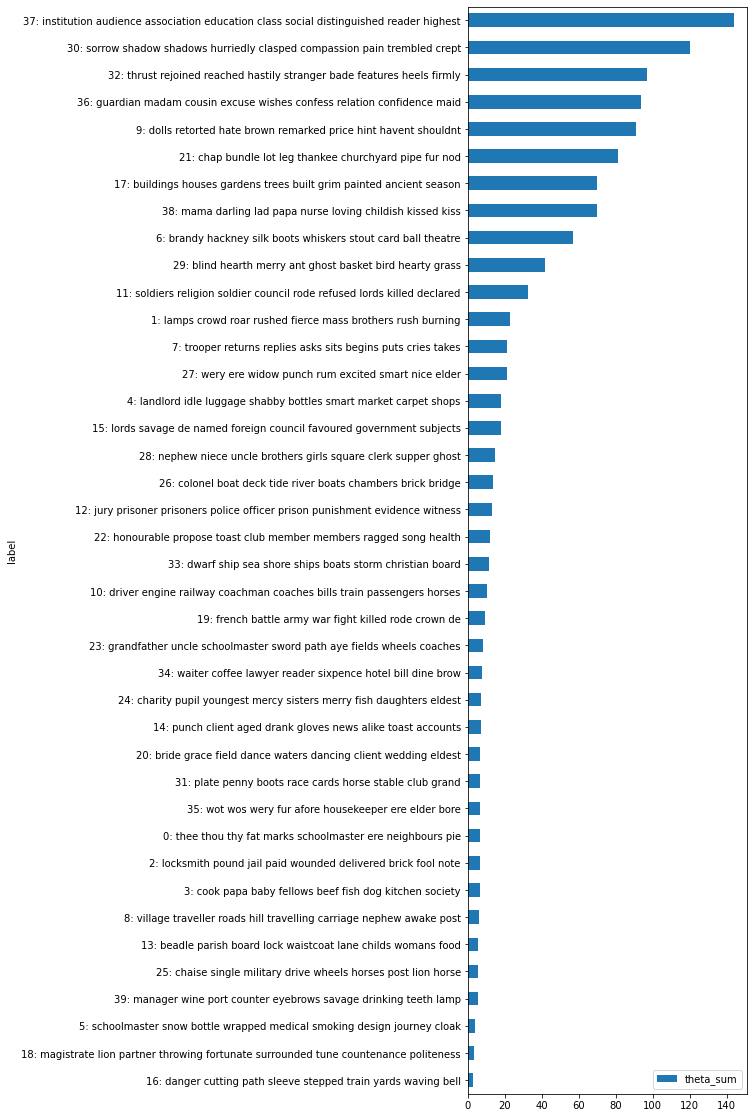

In [18]:
tm.plot_topics()

In [19]:
# table with distribution of topics for each doc
tm.THETA

topic_id               0         1         2         3         4         5   \
book_id chap_id                                                               
98      1        0.000188  0.000188  0.000188  0.000188  0.000188  0.000188   
        2        0.000088  0.000088  0.000088  0.000088  0.000088  0.000088   
        3        0.000110  0.000110  0.000110  0.000110  0.000110  0.000110   
        4        0.000044  0.000044  0.000044  0.000044  0.029046  0.000044   
        5        0.004181  0.147800  0.000043  0.000043  0.000043  0.000043   
...                   ...       ...       ...       ...       ...       ...   
35536   9        0.063746  0.000171  0.000171  0.000171  0.000171  0.000171   
        10       0.103054  0.216522  0.000455  0.000455  0.000455  0.000455   
        11       0.000212  0.000212  0.000212  0.000212  0.000212  0.000212   
        12       0.000333  0.000333  0.000333  0.000333  0.000333  0.000333   
        13       0.983475  0.000424  0.000424  0.000424  0.000424  0.000424   

topic_id               6         7         8         9   ...        30  \
book_id chap_id                                          ...             
98      1        0.000188  0.000188  0.000188  0.000188  ...  0.000188   
        2        0.000088  0.000088  0.000088  0.000088  ...  0.000088   
        3        0.000110  0.000110  0.000110  0.000110  ...  0.471101   
        4        0.119610  0.000044  0.024166  0.032959  ...  0.219375   
        5        0.000043  0.000043  0.000043  0.000043  ...  0.170054   
...                   ...       ...       ...       ...  ...       ...   
35536   9        0.000171  0.000171  0.000171  0.000171  ...  0.000171   
        10       0.000455  0.000455  0.000455  0.000455  ...  0.000455   
        11       0.000212  0.000212  0.000212  0.000212  ...  0.486773   
        12       0.000333  0.000333  0.000333  0.000333  ...  0.470581   
        13       0.000424  0.000424  0.000424  0.000424  ...  0.000424   

topic_id               31        32        33        34        35        36  \
book_id chap_id                                                               
98      1        0.000188  0.000188  0.000188  0.000188  0.000188  0.000188   
        2        0.000088  0.000088  0.000088  0.000088  0.000088  0.000088   
        3        0.000110  0.000110  0.000110  0.000110  0.000110  0.000110   
        4        0.000044  0.000044  0.036325  0.021987  0.000044  0.208900   
        5        0.000043  0.116643  0.011718  0.000043  0.000043  0.000043   
...                   ...       ...       ...       ...       ...       ...   
35536   9        0.000171  0.000171  0.735679  0.000171  0.020780  0.000171   
        10       0.000455  0.000455  0.159068  0.000455  0.000455  0.000455   
        11       0.000212  0.000212  0.133630  0.000212  0.000212  0.000212   
        12       0.000333  0.000333  0.112076  0.000333  0.000333  0.000333   
        13       0.000424  0.000424  0.000424  0.000424  0.000424  0.000424   

topic_id               37        38        39  
book_id chap_id                                
98      1        0.000188  0.000188  0.000188  
        2        0.000088  0.000088  0.000088  
        3        0.000110  0.000110  0.000110  
        4        0.000044  0.000044  0.000044  
        5        0.000043  0.000043  0.329920  
...                   ...       ...       ...  
35536   9        0.000171  0.000171  0.000171  
        10       0.258831  0.000455  0.000455  
        11       0.000212  0.000212  0.000212  
        12       0.128610  0.000333  0.000333  
        13       0.000424  0.000424  0.000424  

[1182 rows x 40 columns]

In [20]:
# distrubution of words over topics
tm.PHI

term_str         lie  understood      youth      third     quickly  \
topic_id                                                             
0           0.025000    0.025000  11.751554   0.025000    0.025000   
1          12.812068    0.025000   0.025000   9.663417    0.025000   
2           0.025000    4.280178   0.025000   5.442221    3.280720   
3           0.025000    4.667417   1.360998   0.025000    0.025000   
4           0.025000    1.138922   0.025000  34.606390    0.027057   
5           0.025000    0.025000   1.743291   2.077884    0.025000   
6           0.025000   15.103489   0.025000  55.330021    0.025000   
7          15.329177    9.860270   7.410073   0.025000    4.568890   
8           1.476239    0.025000   0.025000   4.418940    0.034412   
9          17.413441   47.980245  47.235042  24.647709   32.139769   
10          0.025000    7.102742   0.025000   6.487948    8.816408   
11          0.025000    4.368480   0.025000  28.657035   18.196925   
12          5.345035    0.025000   0.025000   3.588518    0.025000   
13          0.025000    0.025000   2.969477   0.025000    0.025000   
14          0.025000    3.209910   0.025000   0.025000    0.025000   
15          2.483488    7.096558  10.364135  22.040881    0.025000   
16          0.025000    2.316688   1.039195   4.086619    4.202465   
17         98.959734    6.335168  10.413182  31.841678    8.840451   
18          1.614629    0.025000   0.025000   0.025000    1.279513   
19          1.412702    0.025000   7.157730  20.303078    0.025000   
20          0.025000    9.854981  20.248930   0.025000    3.502576   
21         41.048301   40.170254  19.307265  22.998346    3.833785   
22          0.025000    1.040363   0.025000   0.025000    0.025000   
23          0.025000    0.025000   0.025000   0.025000    4.000744   
24          0.025000    7.422136  49.838859   0.025000    0.025000   
25          0.025000    0.025000   1.431668   1.669838    0.025000   
26          2.887782   15.308292   0.025000   9.385745    0.025000   
27          1.385641    4.261198   0.207395  18.903448   13.199940   
28          0.025000    0.025000  19.575153   0.025000    6.220376   
29         27.047825    0.025000   8.362203   0.025000   15.968917   
30        136.305300   17.793508  48.049766  48.845857  116.075363   
31          0.025000    0.025000   0.025000   0.025000    0.025000   
32         23.866075    0.025000   6.755022  24.154232  108.327798   
33          0.025000    7.790811   0.025000   0.025000    7.007532   
34          0.025000    0.025000   5.137558   3.162239    0.025004   
35          0.025000    8.280918   0.025000   0.025000    2.040621   
36          1.909779   77.488227  44.040666   9.478441   26.925608   
37         19.086118   72.326728  59.306196  44.784513    2.956403   
38         25.066668   59.402517  50.869642   0.025000   40.929058   
39          0.025000    0.025000   0.025000   0.025000    4.224665   

term_str  difficulty       weak     kitchen      placed  consequence  ...  \
topic_id                                                              ...   
0           3.262398   0.025000    1.856540    7.386199     0.025000  ...   
1          11.992605   0.025000    2.344881    0.025000     0.025000  ...   
2           0.025000   0.025000    0.025000    0.025000     0.025000  ...   
3           1.254139   1.199507   22.825442    1.476878     0.025000  ...   
4           5.846419  17.142279    0.025000    6.983442    11.679474  ...   
5           7.946871   0.025000    9.564793    0.025000     0.107761  ...   
6          31.046006   0.025000   70.237688   15.392848   100.372561  ...   
7           6.134426  10.463160    0.025000    0.025000     5.307817  ...   
8           0.025000   0.025000    0.025000    0.025000     0.025000  ...   
9          18.499233  55.647671   40.239575    6.721286    50.362425  ...   
10          0.025000   0.025000    0.025000    1.209200     0.025000  ...   
11         15.769301  29.126880    4.149390   19.089999   

In [21]:
tm.TOPIC.sort_values('theta_sum', ascending = False)

phi_sum   theta_sum      h  \
topic_id                                    
37        61499.551297  143.579508  10.12   
30        62807.348840  119.986306   9.99   
32        53922.415636   96.720517  10.07   
36        55886.255698   93.561189  10.15   
9         51910.885690   90.708829  10.16   
21        46285.859104   81.136282  10.07   
17        43945.628765   69.992820   9.90   
38        41487.755610   69.599950  10.06   
6         32009.362092   56.846382   9.65   
29        23761.898690   41.652583   9.66   
11        17767.267836   32.324709   9.57   
1         11037.564733   22.715944   8.97   
7         10328.489388   21.056573   8.62   
27        13008.275634   20.915748   9.56   
4         10984.966741   17.975642   9.17   
15         8799.698888   17.715621   9.19   
28         7192.831248   14.580303   8.85   
26         7005.464802   13.339811   8.42   
12         7121.281232   12.985642   8.33   
22         3814.899205   11.799269   8.38   
33         5566.574329   11.501317   8.34   
10         5522.554745   10.533876   8.40   
19         4884.785353    9.194422   8.44   
23         4493.800657    7.960685   8.40   
34         2601.979589    7.701786   8.22   
24         4033.945328    6.918712   7.97   
14         1731.221631    6.882468   8.92   
20         4135.461960    6.734693   8.45   
31         2838.494836    6.616429   8.15   
35         4065.736007    6.508327   8.11   
0          3283.886528    6.490354   8.12   
2          1970.532319    6.455095   8.34   
3          2835.357018    6.401074   9.14   
8          3026.361312    5.852191   7.60   
13         2535.695729    5.711818   8.11   
25         2308.756196    5.379319   7.92   
39         2375.148475    5.329834   7.92   
5          2026.085858    4.125338   8.49   
18         1548.489716    3.473238   8.38   
16         1529.431283    3.035389   8.68   

                                              top_terms_rel  \
topic_id                                                      
37        institution audience association education cla...   
30        sorrow shadow shadows hurriedly clasped compas...   
32        thrust rejoined reached hastily stranger bade ...   
36        guardian madam cousin excuse wishes confess re...   
9         dolls retorted hate brown remarked price hint ...   
21        chap bundle lot leg thankee churchyard pipe fu...   
17        buildings houses gardens trees built grim pain...   
38        mama darling lad papa nurse loving childish ki...   
6         brandy hackney silk boots whiskers stout card ...   
29        blind hearth merry ant ghost basket bird heart...   
11        soldiers religion soldier council rode refused...   
1         lamps crowd roar rushed fierce mass brothers r...   
7         trooper returns replies asks sits begins puts ...   
27        wery ere widow punch rum excited smart nice elder   
4         landlord idle luggage shabby bottles smart mar...   
15        lords savage de named foreign council favoured...   
28        nephew niece uncle brothers girls square clerk...   
26        colonel boat deck tide river boats chambers br...   
12        jury prisoner prisoners police officer prison ...   
22        honourable propose toast club member members r...   
33        dwarf ship sea shore ships boats storm christi...   
10        driver engine railway coachman coaches bills t...   
19        french battle army war fight killed rode crown de   
23        grandfather uncle schoolmaster sword path aye ...   
34        waiter coffee lawyer reader sixpence hotel bil...   
24        charity pupil youngest mercy sisters merry fis...   
14        punch client aged drank gloves news alike toas...   
20        bride grace field dance waters dancing client ...   
31        plate penny boots race cards horse stable club...   
35        wot wos wery fur afore housekeeper ere elder bore   
0         thee thou thy fat marks schoolmaster ere neigh...   
2         locksmith pound jail paid wounded d

### **Top terms associated with the most frequent topic**

In [22]:
top_topic = tm.TOPIC.theta_sum.idxmax()

top_topic

37

In [23]:
tm.TOPIC.sort_values('theta_sum', ascending = False).loc[top_topic, 'top_terms_rel']

'institution audience association education class social distinguished reader highest'

In [24]:
# find topic (theta) that is most frequent (highest total prob across all docs) and take that topics top 5 terms
top_five_terms = tm.TOPIC.sort_values('theta_sum', ascending = False).loc[top_topic, 'top_terms_rel'].split()[:5]

In [25]:
top_five_terms

['institution', 'audience', 'association', 'education', 'class']

In [62]:
# join THETA and LIB tables
joint_theta = tm.THETA.join(LIB)

# add title column to index
joint_theta = joint_theta.set_index('title', append = True)

# drop other LIB cols and get mean topic distribution for each book
book_mean_theta = joint_theta.drop(joint_theta.loc[:, 'year':].columns, axis = 1).groupby(['book_id', 'title', 'type']).mean()

book_mean_theta.style.background_gradient(axis=None)

In [66]:
# most common topics by work type
book_mean_theta.groupby('type').mean().idxmax(axis = 1)

type
non-fiction    37
novel          30
stories        37
dtype: int64

In [80]:
# table with most popular topic for each book --> rename new col created to topic_id and set index to topic_id for join below
max_topic = book_mean_theta.apply(lambda x: x.idxmax(), axis = 1).reset_index().rename({0: 'topic_id'}, axis = 1).set_index('topic_id')

# join with tm.TOPIC for words for each topic
max_topic = max_topic.join(tm.TOPIC).reset_index().set_index('book_id')

max_topic['top_five_terms'] = max_topic.apply(lambda x: x.top_terms_rel.split()[:5], axis = 1)

max_topic.sort_values('topic_id', ascending = False).drop('label', axis = 1).style.background_gradient(cmap='YlGnBu', subset = ['topic_id'])

### **Works and Top Terms Associated with Each Topic**

In [109]:
# set option so that columns not truncated
pd.set_option('display.max_colwidth', None)

In [110]:
works_df = max_topic.groupby('topic_id').agg({'topic_id': 'size', 'title': lambda x: ', '.join(x)}) \
                    .rename({'topic_id': 'count'}, axis = 1) \
                    .sort_values('count', ascending = False)

works_df['top_terms_rel'] = tm.TOPIC.top_terms_rel

works_df

count  \
topic_id          
37            9   
21            7   
30            6   
17            4   
32            4   
38            3   
9             3   
29            2   
36            2   
16            1   
11            1   
20            1   
4             1   
27            1   
10            1   
33            1   
34            1   
6             1   
3             1   

                                                                                                                                                                                                                                                          title  \
topic_id                                                                                                                                                                                                                                                          
37        master humphreys clock, hunted down, george silvermans explanation, speeches of charles dickens, the mudfog and other sketches, sketches of young couples, sketches of young gentlemen, miscellaneous papers, the poems and verses of charles dickens   
21                                                                                                                  the holly tree, great expectations, a message from the sea, tom tiddlers ground, somebodys luggage, doctor marigold, mrs lirripers lodgings   
30                                                                                                                                 a tale of two cities, the haunted man and the ghosts bargain, the chimes, hard times, some christmas stories, a house to let   
17                                                                                                                                                                            pictures from italy, american notes, reprinted pieces, the uncommerical traveller   
32                                                                                                                                                                                       the old curiosity shop, oliver twist, barnaby rudge, nicholas nickleby   
38                                                                                                                                                                                                     david copperfield, dombey and sons, mrs lirripers legacy   
9                                                                                                                                                                                                         our mutual friend, the lamplighter, martin chuzzlewit   
29                                                                                                                                                                                                                 a christmas carol, the cricket on the hearth   
36                                                                                                                                                                                                                      the mystery of edwin drood, bleak house   
16                                                                                                                                                                                                                                          three ghost stories   
11                                                                                                                                                                                                                                  a childs history of england   
20                                                                                                                                                                                                                                           the ba

In [111]:
# reset width to default: https://pandas.pydata.org/docs/user_guide/options.html
pd.set_option('display.max_colwidth', 50)

## **M09: Word Embeddings**

In [28]:
w2v_params = dict(
    min_count = 10,
    workers = 1,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [29]:
SENTS = CORPUS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

In [30]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [31]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [32]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                               
0        -0.086669  0.040908  0.093690  0.034416  0.038068 -0.176783   
1        -0.108333  0.138857  0.135974  0.027027  0.064037 -0.160321   
1841     -0.020596  0.155038  0.096934  0.055339 -0.058595 -0.225135   
1842     -0.042258  0.149591  0.054136  0.151247  0.021083 -0.241527   
1844      0.056815  0.099444  0.027985  0.069834 -0.027610 -0.272625   

                6         7         8         9   ...        90        91  \
term_str                                          ...                       
0         0.064615  0.325522 -0.201402 -0.059309  ... -0.027102  0.049776   
1         0.058961  0.240217 -0.178135 -0.131519  ...  0.088589  0.072201   
1841     -0.012934  0.295945 -0.087681 -0.080777  ...  0.074726  0.134761   
1842     -0.052447  0.246394 -0.159502 -0.041531  ...  0.090793  0.042792   
1844      0.030844  0.289546 -0.121384 -0.097523  ...  0.122137  0.062127   

                92        93        94        95        96        97  \
term_str                                                               
0         0.054806  0.000187  0.199081  0.015421  0.111112 -0.124083   
1         0.064821  0.013996  0.273740  0.138053  0.101080 -0.082708   
1841      0.147150 -0.007001  0.171999  0.020726  0.025451 -0.071513   
1842      0.158773  0.020828  0.189168  0.105165  0.095324 -0.106520   
1844      0.137725  0.015633  0.186914  0.072275  0.078315 -0.121382   

                98        99  
term_str                      
0        -0.011471 -0.004024  
1         0.014898 -0.087596  
1841     -0.042018 -0.054212  
1842      0.012464 -0.106773  
1844      0.002132 -0.153330  

[5 rows x 100 columns]

In [33]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random', # 'pca'
    n_iter = 2500,
    random_state = 23    
)

In [34]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [35]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index).join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [36]:
COORDS['log_n'] = np.log(COORDS['n'])

In [37]:
COORDS

x          y   n       dfidf pos_group     log_n
term_str                                                            
0            6.764849  -7.233729  60   45.732311        CD  4.094345
1            5.966598  -7.085509  38  134.929244        CD  3.637586
1841       -11.627644 -28.026684  11   63.333804        CD  2.397895
1842         4.192721  -2.623560  17   68.850862        CD  2.833213
1844         4.297374  -2.655729  12   51.797616        CD  2.484907
...               ...        ...  ..         ...       ...       ...
zealous    -50.287689  32.855015  51  221.858487        JJ  3.931826
zenith     -48.237213 -23.476273  12   79.464622        NN  2.484907
zest       -53.370853 -10.908454  18  108.667608        NN  2.890372
zoological   4.185986 -24.232597  10   63.333804        JJ  2.302585
à           -6.250517  76.625725  50   74.223410        NN  3.912023

[16515 rows x 6 columns]

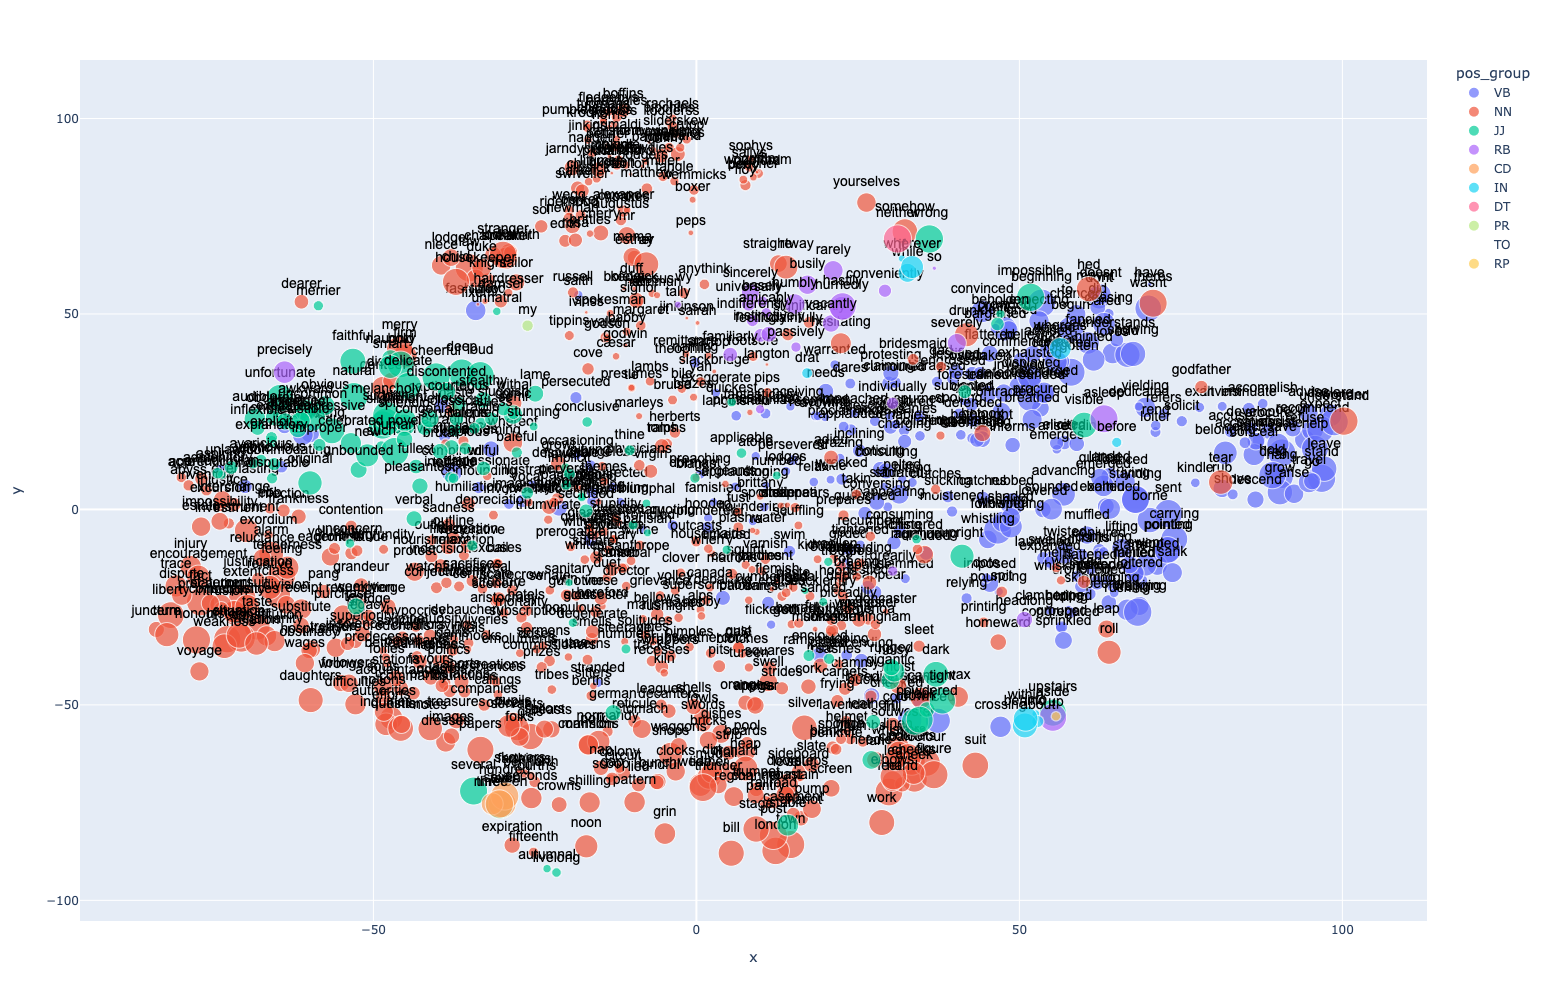

In [112]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

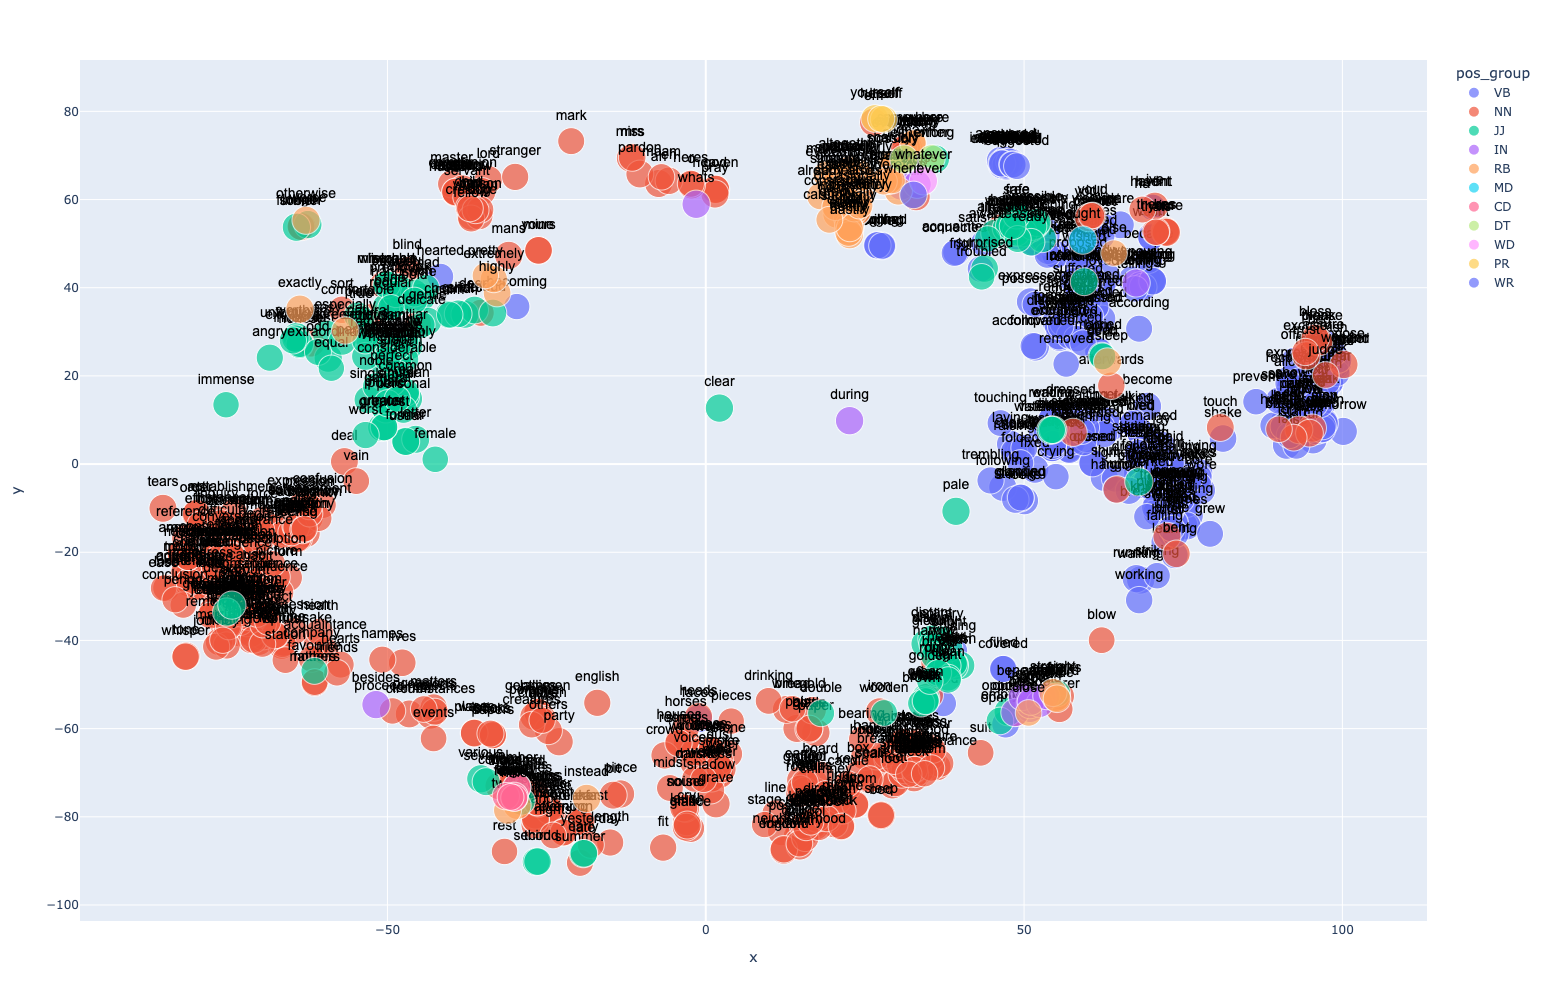

In [113]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

#### **With Nouns Only (not proper ones)**

In [67]:
noun_COORDS = COORDS.loc[COORDS.pos_group == 'NN']

noun_COORDS

x          y    n       dfidf pos_group     log_n
term_str                                                              
aaron       -14.241907  95.049797   16   32.828057        NN  2.772589
aback       -21.607054 -14.214270   19   99.312229        NN  2.944439
abandonment -46.959370  -8.260768   14   84.585470        NN  2.639057
abbey        10.990131  84.507027  184  237.391975        NN  5.214936
abbeys        8.985194  86.130791   12   39.425431        NN  2.484907
...                ...        ...  ...         ...       ...       ...
yup           9.715828  47.414139   11   10.207014        NN  2.397895
zeal        -58.171692 -14.548573   43  202.217270        NN  3.761200
zenith      -48.237213 -23.476273   12   79.464622        NN  2.484907
zest        -53.370853 -10.908454   18  108.667608        NN  2.890372
à            -6.250517  76.625725   50   74.223410        NN  3.912023

[9450 rows x 6 columns]

#### **Noun tSNE plot**

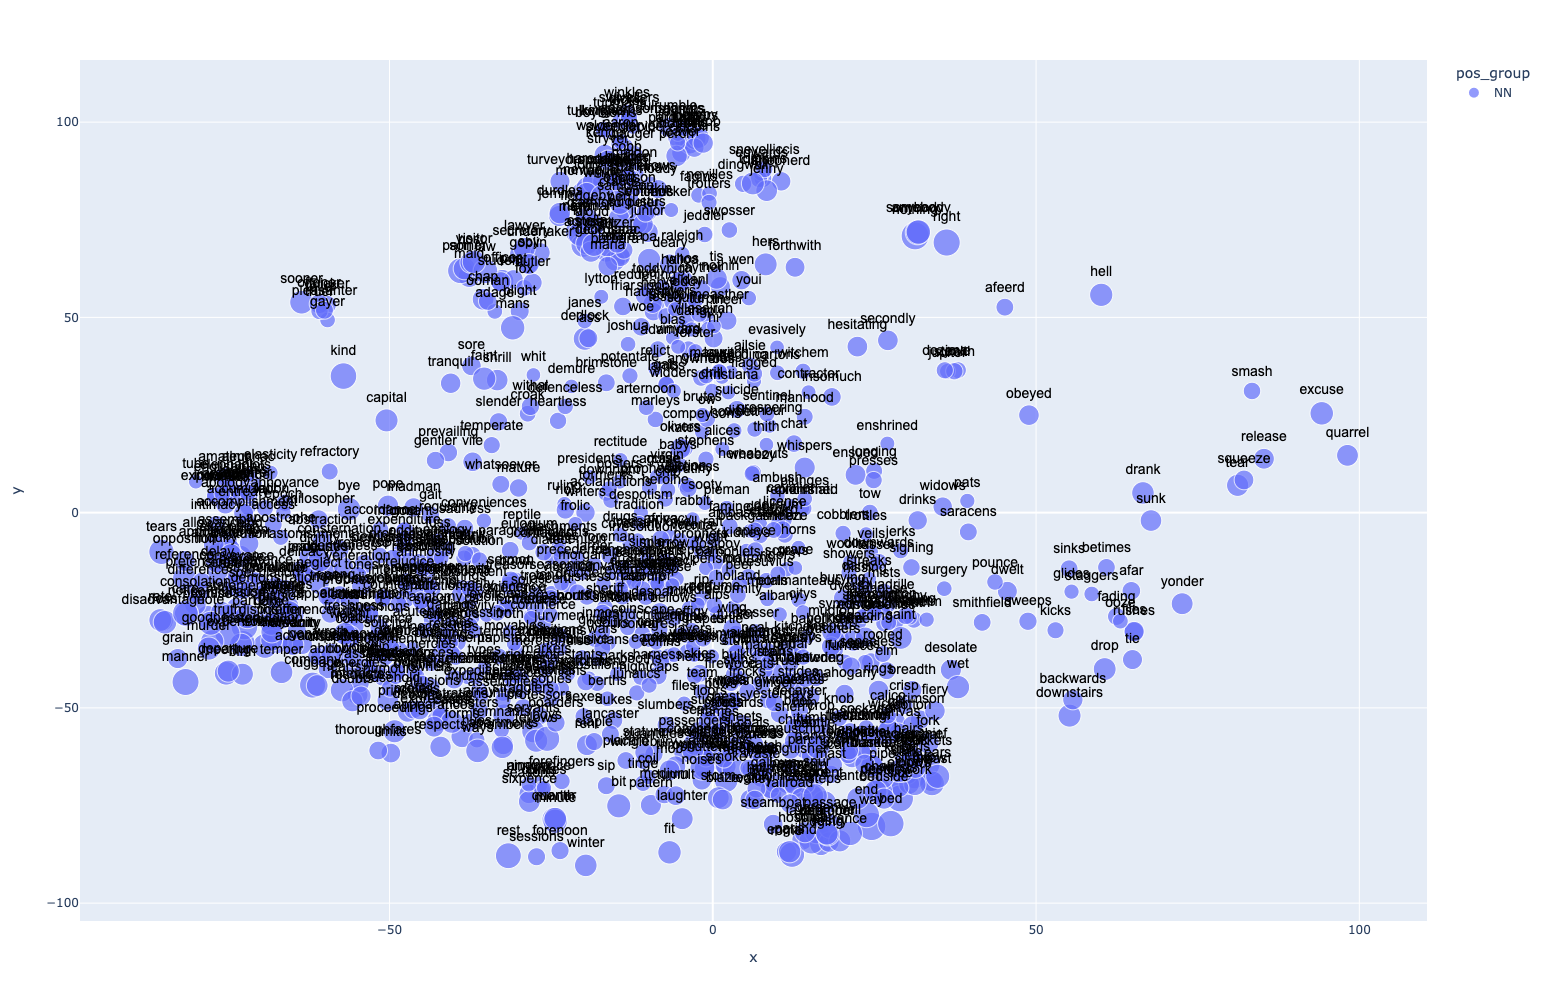

In [114]:
px.scatter(noun_COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',
           size = 'log_n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

#### **Clusters in Nouns Plot**
* ease, liberty, credit, comfort, use, reign $\rightarrow$ idea that comfort, ease related to money, reign... class differences?
* mistrust, warrant, venture, judge, play $\rightarrow$ trust and judgment??
* nurse, servant, housekeeper, lad, boy, fellow, physician $\rightarrow$ domestic occupations / roles (gender roles also...??)
* collision, dart, crack, fight, rolls, ooze, plough, whisking $\rightarrow$ action, trepidation??
* courtyard, chapel, prison, house, room $\rightarrow$ locations where many scenes occur

### **Analogies and Similarities (vector algebra)**

In [40]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [41]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0   girl  0.837573
1   baby  0.777271
2  child  0.754371

In [42]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0     son  0.798225
1  sister  0.772192
2    wife  0.757186

In [43]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0     niece  0.781419
1  daughter  0.780853
2    father  0.768486

In [44]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0         lady  0.795574
1  housekeeper  0.761616
2        widow  0.739700
3         girl  0.737553
4       priest  0.701211

In [45]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0    gentleman  0.786933
1       person  0.630580
2    clergyman  0.606372
3  housekeeper  0.582045
4       genlmn  0.570784

In [46]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0    moon  0.775283
1    wind  0.751996
2    rain  0.725211
3     sky  0.721906
4  clouds  0.717258

In [115]:
complete_analogy('king', 'rich', 'servant', 5)

term       sim
0  handsome  0.684049
1    shabby  0.681852
2      nice  0.668962
3     queer  0.638489
4     smart  0.619074

In [116]:
complete_analogy('lord', 'rich', 'servant', 5)

term       sim
0    shabby  0.690646
1      tall  0.620994
2      neat  0.619176
3  handsome  0.602545
4     dirty  0.597426

In [117]:
complete_analogy('man', 'journey', 'woman', 5)

term       sim
0     voyage  0.703066
1    arrival  0.602386
2      trial  0.586183
3  departure  0.584255
4        eve  0.583341

In [118]:
complete_analogy('woman', 'marriage', 'man', 5)

term       sim
0      trial  0.686139
1   judgment  0.629092
2    success  0.626624
3    absence  0.619787
4  departure  0.615857

In [119]:
complete_analogy('man', 'property', 'woman', 5)

term       sim
0          sex  0.598334
1    existence  0.597544
2      history  0.596154
3      affairs  0.587139
4  misfortunes  0.586858

In [120]:
complete_analogy('man', 'fool', 'woman', 5)

term       sim
0   wretch  0.687669
1    silly  0.675156
2  creetur  0.664741
3    brute  0.664144
4  villain  0.646810

In [121]:
complete_analogy('woman', 'fool', 'man', 5)

term       sim
0  vagabond  0.628066
1   monster  0.606369
2     devil  0.605471
3     brute  0.586062
4    madman  0.570789

In [122]:
complete_analogy('man', 'wise', 'woman', 5)

term       sim
0     devilish  0.627629
1       artful  0.615905
2  industrious  0.598349
3        handy  0.592551
4  thoughtless  0.591561

In [123]:
complete_analogy('woman', 'wise', 'man', 5)

term       sim
0  reasonable  0.563518
1      useful  0.553319
2    sensible  0.551846
3    uncommon  0.531260
4      absurd  0.530238

## Similarites

In [47]:
get_most_similar('joy')

term       sim
0       grief  0.766438
1     delight  0.747182
2   gratitude  0.740493
3  admiration  0.739902
4  compassion  0.734604
5    sympathy  0.719900
6    contempt  0.703811
7   affection  0.699071
8    firmness  0.689040
9  tenderness  0.684935

In [70]:
get_most_similar('servant')

term       sim
0         maid  0.814667
1        nurse  0.768200
2       lodger  0.754837
3  housekeeper  0.713236
4         wife  0.708198
5        clerk  0.707178
6     daughter  0.704906
7       priest  0.698037
8        niece  0.691128
9     relation  0.687183

In [75]:
get_most_similar('king')

term       sim
0       queen  0.784870
1        duke  0.745500
2        earl  0.684949
3      prince  0.681742
4        pope  0.674839
5   president  0.660339
6       henry  0.626848
7        army  0.620704
8      barons  0.611010
9  archbishop  0.594176

In [76]:
get_most_similar('knowledge')

term       sim
0   experience  0.781393
1        crime  0.739452
2    existence  0.739142
3       memory  0.731023
4       design  0.730296
5       belief  0.729291
6     weakness  0.726590
7       merits  0.724801
8  imagination  0.721957
9       wealth  0.713997

In [71]:
get_most_similar('church')

term       sim
0   cathedral  0.838048
1        hall  0.806354
2         inn  0.801049
3       tower  0.800412
4     gallery  0.791313
5     maypole  0.789417
6     village  0.786119
7  churchyard  0.784754
8      palace  0.784076
9        park  0.773788

In [72]:
get_most_similar('poor')

term       sim
0   wretched  0.647956
1     wicked  0.642902
2      silly  0.641307
3    dearest  0.636960
4  miserable  0.619008
5      brave  0.613389
6    foolish  0.604288
7    darling  0.593470
8       sick  0.591913
9       dear  0.589218

In [77]:
get_most_similar('rich')

term       sim
0    shabby  0.714806
1      rare  0.693201
2    hungry  0.684507
3      lazy  0.684202
4     funny  0.676628
5    clever  0.675720
6   healthy  0.668881
7  handsome  0.667154
8      clad  0.666034
9   thirsty  0.662678

In [73]:
get_most_similar('money')

term       sim
0     trouble  0.642048
1        debt  0.623403
2          em  0.584595
3     shelter  0.566257
4    security  0.564140
5    evidence  0.554088
6     comfort  0.541906
7       match  0.533711
8  employment  0.530339
9     luggage  0.529704

In [74]:
get_most_similar('duty')

term       sim
0   feelings  0.683477
1   weakness  0.646468
2   kindness  0.643070
3    conduct  0.642216
4    readers  0.632523
5     advice  0.632393
6     memory  0.630948
7    consent  0.628821
8  happiness  0.626369
9     belief  0.624754

In [79]:
get_most_similar('kindness')

term       sim
0     friendship  0.771272
1      affection  0.769321
2      happiness  0.761251
3      gratitude  0.754086
4     tenderness  0.752351
5       devotion  0.750932
6  gratification  0.732739
7       goodness  0.731585
8         praise  0.720555
9         vanity  0.716911

In [48]:
get_most_similar('man')

term       sim
0  gentleman  0.836856
1      woman  0.793284
2     person  0.756895
3       lady  0.663957
4    soldier  0.660217
5        dog  0.659054
6  clergyman  0.658894
7        boy  0.643173
8       chap  0.641801
9     priest  0.631909

In [49]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0     further  0.301181
1        high  0.262769
2  particular  0.242779
3     greater  0.242681
4       great  0.240039
5     special  0.238332
6      sooner  0.236409
7       moral  0.235225
8  favourable  0.233940
9        vast  0.232693

In [50]:
get_most_similar(positive='woman')

term       sim
0         girl  0.861149
1          man  0.793284
2     creature  0.791718
3         lady  0.773513
4       wretch  0.771722
5  housekeeper  0.761022
6    gentleman  0.760796
7       priest  0.744040
8          boy  0.735630
9         chap  0.719009

In [51]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0      jane  0.467104
1      miss  0.425777
2  screamed  0.413791
3    sobbed  0.393252
4     lucie  0.392523
5   tippins  0.391272
6   weeping  0.389153
7     maria  0.385204
8   sobbing  0.376695
9      girl  0.368548

In [52]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0   gentleman  0.379001
1         men  0.300544
2     himself  0.290749
3     outward  0.280235
4          an  0.268891
5     violent  0.259708
6  themselves  0.257858
7  suspicious  0.248906
8      change  0.248604
9    stronger  0.245816

# Save

In [53]:
# W2V.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-W2V.csv')
# VOCAB.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-VOCAB.csv')
# SENTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-GENSIM_DOCS.csv')

#### **Sources**

* Dropping multiple columns by name starting with `drop` and `loc`: https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
* Adding a new index level from the columns of a dataframe: https://stackoverflow.com/questions/14744068/prepend-a-level-to-a-pandas-multiindex
* Setting pandas df column width with `pd.set_option(display.max_colwidth', None)` to prevent truncating column values: https://pandas.pydata.org/docs/user_guide/options.html